# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/177/EEGNet_lstm/1-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- Same subject, same session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- New subject: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- New subject: EEGNet with bidirectional ConvLSTM2D
   - Results (TODO)
   - Longer window experiment (TODO)

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8021 @ epoch 75                         | 0.5685 @ epoch 170                    | 0.7083                                                | 0.7135                                                 |
| C           | 0.901 @ epoch 301                         | 0.3569 @ epoch 376                    | 0.9062                                                | 0.8958                                                 |
| E           | 0.9058 @ epoch 478                        | 0.3463 @ epoch 400                    | 0.8272                                                | 0.8272                                                 |

With comparable results it is clear that the extension didn't yield improvements nor caused any major issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
This is to be expected given the amount of trainable parameters is increased in such an extreme manner.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.

The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr>

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 128 (from 64)
   - Further increase to 192 was not beneficial in this experiment 

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8802 @ epoch 383                   | 0.3736 @ epoch 632               | 0.7708                                           | 0.7812                                            |
| C           | 0.9479 @ epoch 2290                  | 0.2454 @ epoch 1094              | 0.9531                                           | 0.9375                                            |
| E           | 0.9529 @ epoch 896                   | 0.1631 @ epoch 1224              | 0.9319                                           | 0.9215                                            |

EEGNet with LSTM:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8385 @ epoch 350                   | 0.5532 @ epoch 360               | 0.7396                                           | 0.75                                              |
| C           | 0.8958 @ epoch 920                   | 0.3792 @ epoch 664               | 0.8594                                           | 0.8802                                            |
| E           | 0.9058 @ epoch 81                    | 0.3552 @ epoch 273               | 0.8115                                           | 0.8272                                            |

Whilst the accuracy improved for the test set significantly for subject C and E, the added complexity and overfitting tendencies is something that should be taken into account when working with longer windows.

The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss_long.png)

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 128, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.3, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        LSTM_size = 128, # Amount of units in LSTM layer
        ltsm_dropout = 0.6,
        ltsm_l1 = 0.0005,
        ltsm_l2 = 0.0005
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_long_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.8177 @ epoch 448                             | 0.5194 @ epoch 345                         | 0.7083                                                     | 0.6927                                                      |
| C           | 0.8906 @ epoch 187                             | 0.3887 @ epoch 44                          | 0.8854                                                     | 0.8854                                                      |
| E           | 0.9215 @ epoch 339                             | 0.2673 @ epoch 443                         | 0.8429                                                     | 0.8639                                                      |


Again, for the most part results seems comparable although the result for subject B is considerably lower then EEGNet.
The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 2500 epochs due to the increased amount of data, saving the best model based on best validation accuracy and validation loss (0.3 validation split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6458 @ epoch 177                             | 0.8297 @ epoch 147                         | 0.6302                                                     | 0.6188                                                      |
| C           | 0.8681 @ epoch 947                             | 0.4117 @ epoch 782                         | 0.6726                                                     | 0.6851                                                      |
| E           | 0.7361 @ epoch 166                             | 0.6617 @ epoch 75                          | 0.6513                                                     | 0.6702                                                      |

Again, no real increase nor decrease in performance is made with the LSTM extension

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/Loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 192 (from 64)
   - Increase to 192 was beneficial in this experiment due to increased data complexity

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.7378 @ epoch 2483                  | 0.6887 @ epoch 204               | 0.6677                                           | 0.674                                             |
| C           | 0.9149 @ epoch 885                   | 0.3764 @ epoch 208               | 0.6392                                           | 0.6267                                            |
| E           | 0.8333 @ epoch 233                   | 0.4867 @ epoch 302               | 0.7707                                           | 0.7812                                            |

EEGNet with LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.6892 @ epoch 246                        | 0.8028 @ epoch 108                    | 0.6573                                                | 0.6406                                                 |
| C           | 0.875 @ epoch 53                          | 0.4447 @ epoch 285                    | 0.6548                                                | 0.6434                                                 |
| E           | 0.7934 @ epoch 197                        | 0.5842 @ epoch 96                     | 0.6932                                                | 0.6827                                                 |

The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/loss_long.png)

In [6]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 192, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 21, 300, 16)       2400      
                                                                 
 batch_normalization_3 (Batc  (None, 21, 300, 16)      64        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 300, 64)       1344      
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 300, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 1, 300, 64)        0         
                                                      

In [7]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 192, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_longer_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (1918, 21, 300)
Epoch 1/1000
11/11 [==============================] - ETA: 0s - loss: 2.1337 - accuracy: 0.3592
Epoch 1: val_loss improved from inf to 2.01299, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.36806, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 8s 310ms/step - loss: 2.1337 - accuracy: 0.3592 - val_loss: 2.0130 - val_accuracy: 0.3681
Epoch 2/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.9263 - accuracy: 0.3703
Epoch 2: val_loss improved from 2.01299 to 1.81362, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsess

Epoch 17/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0594 - accuracy: 0.4734
Epoch 17: val_loss improved from 1.04387 to 1.03497, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy did not improve from 0.52257
11/11 [==============================] - 1s 94ms/step - loss: 1.0605 - accuracy: 0.4769 - val_loss: 1.0350 - val_accuracy: 0.5156
Epoch 18/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0448 - accuracy: 0.4883
Epoch 18: val_loss did not improve from 1.03497

Epoch 18: val_accuracy did not improve from 0.52257
11/11 [==============================] - 1s 88ms/step - loss: 1.0428 - accuracy: 0.4925 - val_loss: 1.0653 - val_accuracy: 0.4826
Epoch 19/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0349 - accuracy: 0.4984
Epoch 19: val_loss did not improve from 1.03497

Epoch 19: val_accuracy did not improve from 0.52257
11/11 [======

Epoch 37/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9937 - accuracy: 0.5203
Epoch 37: val_loss improved from 0.96628 to 0.96559, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 37: val_accuracy did not improve from 0.57465
11/11 [==============================] - 2s 151ms/step - loss: 0.9957 - accuracy: 0.5201 - val_loss: 0.9656 - val_accuracy: 0.5347
Epoch 38/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0056 - accuracy: 0.5094
Epoch 38: val_loss did not improve from 0.96559

Epoch 38: val_accuracy did not improve from 0.57465
11/11 [==============================] - 1s 98ms/step - loss: 1.0039 - accuracy: 0.5127 - val_loss: 0.9879 - val_accuracy: 0.5347
Epoch 39/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.9817 - accuracy: 0.5398
Epoch 39: val_loss improved from 0.96559 to 0.96060, saving model to saved_variables/7/EEGNet_lstm/samesubject_di

11/11 [==============================] - 1s 103ms/step - loss: 0.9077 - accuracy: 0.6043 - val_loss: 0.8721 - val_accuracy: 0.6476
Epoch 58/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8881 - accuracy: 0.6305
Epoch 58: val_loss did not improve from 0.87214

Epoch 58: val_accuracy did not improve from 0.64757
11/11 [==============================] - 1s 94ms/step - loss: 0.8962 - accuracy: 0.6252 - val_loss: 0.9034 - val_accuracy: 0.6163
Epoch 59/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8831 - accuracy: 0.6211
Epoch 59: val_loss improved from 0.87214 to 0.86793, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 59: val_accuracy improved from 0.64757 to 0.64931, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 99ms/step - loss: 0.8828 - accura


Epoch 79: val_accuracy did not improve from 0.66667
11/11 [==============================] - 1s 90ms/step - loss: 0.8430 - accuracy: 0.6386 - val_loss: 0.8499 - val_accuracy: 0.6406
Epoch 80/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8465 - accuracy: 0.6367
Epoch 80: val_loss did not improve from 0.82862

Epoch 80: val_accuracy did not improve from 0.66667
11/11 [==============================] - 1s 86ms/step - loss: 0.8436 - accuracy: 0.6386 - val_loss: 0.8834 - val_accuracy: 0.6319
Epoch 81/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.8158 - accuracy: 0.6516
Epoch 81: val_loss improved from 0.82862 to 0.82727, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 81: val_accuracy did not improve from 0.66667
11/11 [==============================] - 1s 93ms/step - loss: 0.8142 - accuracy: 0.6535 - val_loss: 0.8273 - val_accuracy: 0.6545
Epoch 82/1000
10/11 [=======

11/11 [==============================] - 1s 84ms/step - loss: 0.7940 - accuracy: 0.6818 - val_loss: 0.8277 - val_accuracy: 0.6580
Epoch 104/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7854 - accuracy: 0.6789
Epoch 104: val_loss did not improve from 0.82241

Epoch 104: val_accuracy did not improve from 0.66667
11/11 [==============================] - 1s 85ms/step - loss: 0.7875 - accuracy: 0.6766 - val_loss: 0.8557 - val_accuracy: 0.6441
Epoch 105/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7925 - accuracy: 0.6680
Epoch 105: val_loss did not improve from 0.82241

Epoch 105: val_accuracy did not improve from 0.66667
11/11 [==============================] - 1s 84ms/step - loss: 0.7923 - accuracy: 0.6684 - val_loss: 0.8628 - val_accuracy: 0.6476
Epoch 106/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7791 - accuracy: 0.6969
Epoch 106: val_loss did not improve from 0.82241

Epoch 106: val_accuracy improved from 0.66667 to 0.66840, sa

11/11 [==============================] - 1s 85ms/step - loss: 0.7432 - accuracy: 0.7049 - val_loss: 0.8556 - val_accuracy: 0.6667
Epoch 128/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7557 - accuracy: 0.6898
Epoch 128: val_loss did not improve from 0.80281

Epoch 128: val_accuracy did not improve from 0.66840
11/11 [==============================] - 1s 86ms/step - loss: 0.7496 - accuracy: 0.6945 - val_loss: 0.8363 - val_accuracy: 0.6476
Epoch 129/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7299 - accuracy: 0.7078
Epoch 129: val_loss did not improve from 0.80281

Epoch 129: val_accuracy did not improve from 0.66840
11/11 [==============================] - 1s 85ms/step - loss: 0.7335 - accuracy: 0.7072 - val_loss: 0.8435 - val_accuracy: 0.6562
Epoch 130/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7467 - accuracy: 0.6883
Epoch 130: val_loss did not improve from 0.80281

Epoch 130: val_accuracy did not improve from 0.66840
11/11 [

11/11 [==============================] - 1s 85ms/step - loss: 0.7285 - accuracy: 0.7042 - val_loss: 0.8757 - val_accuracy: 0.6406
Epoch 152/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7195 - accuracy: 0.7258
Epoch 152: val_loss did not improve from 0.80281

Epoch 152: val_accuracy improved from 0.67535 to 0.68750, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 90ms/step - loss: 0.7325 - accuracy: 0.7198 - val_loss: 0.8045 - val_accuracy: 0.6875
Epoch 153/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7513 - accuracy: 0.6898
Epoch 153: val_loss did not improve from 0.80281

Epoch 153: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 83ms/step - loss: 0.7514 - accuracy: 0.6908 - val_loss: 0.8411 - val_accuracy: 0.6458
Epoch 154/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7

Epoch 176/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7111 - accuracy: 0.7211
Epoch 176: val_loss did not improve from 0.80281

Epoch 176: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 84ms/step - loss: 0.7126 - accuracy: 0.7206 - val_loss: 0.8338 - val_accuracy: 0.6701
Epoch 177/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6857 - accuracy: 0.7352
Epoch 177: val_loss did not improve from 0.80281

Epoch 177: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 86ms/step - loss: 0.6865 - accuracy: 0.7332 - val_loss: 0.8395 - val_accuracy: 0.6597
Epoch 178/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6832 - accuracy: 0.7266
Epoch 178: val_loss did not improve from 0.80281

Epoch 178: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 84ms/step - loss: 0.6820 - accuracy: 0.7273 - val_loss: 0.8566 - val_accuracy: 0.6684
Epoch 1

Epoch 201/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.7168 - accuracy: 0.7180
Epoch 201: val_loss did not improve from 0.80281

Epoch 201: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 83ms/step - loss: 0.7143 - accuracy: 0.7183 - val_loss: 0.9054 - val_accuracy: 0.6215
Epoch 202/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6903 - accuracy: 0.7297
Epoch 202: val_loss did not improve from 0.80281

Epoch 202: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 83ms/step - loss: 0.6873 - accuracy: 0.7317 - val_loss: 0.8337 - val_accuracy: 0.6545
Epoch 203/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6614 - accuracy: 0.7555
Epoch 203: val_loss did not improve from 0.80281

Epoch 203: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 83ms/step - loss: 0.6700 - accuracy: 0.7511 - val_loss: 0.8561 - val_accuracy: 0.6580
Epoch 2

Epoch 226/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6828 - accuracy: 0.7383
Epoch 226: val_loss did not improve from 0.80281

Epoch 226: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 84ms/step - loss: 0.6815 - accuracy: 0.7407 - val_loss: 0.8706 - val_accuracy: 0.6806
Epoch 227/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6606 - accuracy: 0.7563
Epoch 227: val_loss did not improve from 0.80281

Epoch 227: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 84ms/step - loss: 0.6609 - accuracy: 0.7556 - val_loss: 0.8506 - val_accuracy: 0.6788
Epoch 228/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6410 - accuracy: 0.7734
Epoch 228: val_loss did not improve from 0.80281

Epoch 228: val_accuracy did not improve from 0.68750
11/11 [==============================] - 1s 84ms/step - loss: 0.6451 - accuracy: 0.7697 - val_loss: 0.8417 - val_accuracy: 0.6632
Epoch 2


Epoch 250: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.6943 - accuracy: 0.7303 - val_loss: 0.8827 - val_accuracy: 0.6458
Epoch 251/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6572 - accuracy: 0.7492
Epoch 251: val_loss did not improve from 0.80281

Epoch 251: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 82ms/step - loss: 0.6513 - accuracy: 0.7541 - val_loss: 0.8758 - val_accuracy: 0.6701
Epoch 252/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6361 - accuracy: 0.7781
Epoch 252: val_loss did not improve from 0.80281

Epoch 252: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 83ms/step - loss: 0.6382 - accuracy: 0.7750 - val_loss: 0.8943 - val_accuracy: 0.6545
Epoch 253/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6477 - accuracy: 0.7594
Epoch 253: val_loss did not improve from 0.80281

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.6340 - accuracy: 0.7742
Epoch 275: val_loss did not improve from 0.80281

Epoch 275: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.6261 - accuracy: 0.7779 - val_loss: 0.8581 - val_accuracy: 0.6476
Epoch 276/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6024 - accuracy: 0.7867
Epoch 276: val_loss did not improve from 0.80281

Epoch 276: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.6081 - accuracy: 0.7817 - val_loss: 0.8635 - val_accuracy: 0.6562
Epoch 277/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6001 - accuracy: 0.8008
Epoch 277: val_loss did not improve from 0.80281

Epoch 277: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.6057 - accuracy: 0.7966 - val_loss: 0.9013 - val_accuracy: 0.6649
Epoch 278/1000
10/11 [

Epoch 300/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6276 - accuracy: 0.7773
Epoch 300: val_loss did not improve from 0.80281

Epoch 300: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 83ms/step - loss: 0.6269 - accuracy: 0.7787 - val_loss: 0.8622 - val_accuracy: 0.6719
Epoch 301/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6261 - accuracy: 0.7719
Epoch 301: val_loss did not improve from 0.80281

Epoch 301: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.6257 - accuracy: 0.7757 - val_loss: 0.8478 - val_accuracy: 0.6823
Epoch 302/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6279 - accuracy: 0.7695
Epoch 302: val_loss did not improve from 0.80281

Epoch 302: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.6197 - accuracy: 0.7757 - val_loss: 0.8817 - val_accuracy: 0.6493
Epoch 3

Epoch 325/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5775 - accuracy: 0.8016
Epoch 325: val_loss did not improve from 0.80281

Epoch 325: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.5741 - accuracy: 0.8048 - val_loss: 0.8748 - val_accuracy: 0.6545
Epoch 326/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5866 - accuracy: 0.8039
Epoch 326: val_loss did not improve from 0.80281

Epoch 326: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.5903 - accuracy: 0.8010 - val_loss: 0.8492 - val_accuracy: 0.6632
Epoch 327/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5857 - accuracy: 0.7945
Epoch 327: val_loss did not improve from 0.80281

Epoch 327: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.5859 - accuracy: 0.7943 - val_loss: 0.8816 - val_accuracy: 0.6632
Epoch 3

Epoch 350/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5716 - accuracy: 0.8086
Epoch 350: val_loss did not improve from 0.80281

Epoch 350: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 87ms/step - loss: 0.5756 - accuracy: 0.8077 - val_loss: 0.8722 - val_accuracy: 0.6597
Epoch 351/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5865 - accuracy: 0.7992
Epoch 351: val_loss did not improve from 0.80281

Epoch 351: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 83ms/step - loss: 0.5849 - accuracy: 0.8010 - val_loss: 0.8902 - val_accuracy: 0.6597
Epoch 352/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5590 - accuracy: 0.8125
Epoch 352: val_loss did not improve from 0.80281

Epoch 352: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 83ms/step - loss: 0.5524 - accuracy: 0.8174 - val_loss: 0.9397 - val_accuracy: 0.6424
Epoch 3

Epoch 375/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5499 - accuracy: 0.8188
Epoch 375: val_loss did not improve from 0.80281

Epoch 375: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.5505 - accuracy: 0.8167 - val_loss: 0.9108 - val_accuracy: 0.6510
Epoch 376/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5521 - accuracy: 0.8297
Epoch 376: val_loss did not improve from 0.80281

Epoch 376: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 88ms/step - loss: 0.5512 - accuracy: 0.8286 - val_loss: 0.9283 - val_accuracy: 0.6233
Epoch 377/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5531 - accuracy: 0.8195
Epoch 377: val_loss did not improve from 0.80281

Epoch 377: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 87ms/step - loss: 0.5459 - accuracy: 0.8249 - val_loss: 0.8875 - val_accuracy: 0.6667
Epoch 3

Epoch 400/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5021 - accuracy: 0.8469
Epoch 400: val_loss did not improve from 0.80281

Epoch 400: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 87ms/step - loss: 0.5073 - accuracy: 0.8450 - val_loss: 0.9320 - val_accuracy: 0.6510
Epoch 401/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5283 - accuracy: 0.8305
Epoch 401: val_loss did not improve from 0.80281

Epoch 401: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.5301 - accuracy: 0.8308 - val_loss: 0.9432 - val_accuracy: 0.6476
Epoch 402/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5381 - accuracy: 0.8359
Epoch 402: val_loss did not improve from 0.80281

Epoch 402: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.5411 - accuracy: 0.8338 - val_loss: 0.9479 - val_accuracy: 0.6389
Epoch 4

Epoch 425/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5445 - accuracy: 0.8297
Epoch 425: val_loss did not improve from 0.80281

Epoch 425: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.5417 - accuracy: 0.8316 - val_loss: 0.9412 - val_accuracy: 0.6597
Epoch 426/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5267 - accuracy: 0.8484
Epoch 426: val_loss did not improve from 0.80281

Epoch 426: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.5262 - accuracy: 0.8487 - val_loss: 0.9459 - val_accuracy: 0.6285
Epoch 427/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5312 - accuracy: 0.8273
Epoch 427: val_loss did not improve from 0.80281

Epoch 427: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.5279 - accuracy: 0.8316 - val_loss: 0.9238 - val_accuracy: 0.6701
Epoch 4

Epoch 450/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4817 - accuracy: 0.8484
Epoch 450: val_loss did not improve from 0.80281

Epoch 450: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.4810 - accuracy: 0.8510 - val_loss: 0.9216 - val_accuracy: 0.6476
Epoch 451/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5149 - accuracy: 0.8461
Epoch 451: val_loss did not improve from 0.80281

Epoch 451: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.5115 - accuracy: 0.8472 - val_loss: 0.9164 - val_accuracy: 0.6441
Epoch 452/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4726 - accuracy: 0.8695
Epoch 452: val_loss did not improve from 0.80281

Epoch 452: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 87ms/step - loss: 0.4711 - accuracy: 0.8689 - val_loss: 0.9172 - val_accuracy: 0.6493
Epoch 4

Epoch 475/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4358 - accuracy: 0.8891
Epoch 475: val_loss did not improve from 0.80281

Epoch 475: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.4364 - accuracy: 0.8860 - val_loss: 0.9546 - val_accuracy: 0.6562
Epoch 476/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4569 - accuracy: 0.8758
Epoch 476: val_loss did not improve from 0.80281

Epoch 476: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.4512 - accuracy: 0.8808 - val_loss: 0.9276 - val_accuracy: 0.6458
Epoch 477/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4253 - accuracy: 0.8727
Epoch 477: val_loss did not improve from 0.80281

Epoch 477: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 87ms/step - loss: 0.4328 - accuracy: 0.8689 - val_loss: 0.9637 - val_accuracy: 0.6233
Epoch 4

Epoch 500/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4604 - accuracy: 0.8828
Epoch 500: val_loss did not improve from 0.80281

Epoch 500: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.4559 - accuracy: 0.8852 - val_loss: 0.9848 - val_accuracy: 0.6389
Epoch 501/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4581 - accuracy: 0.8687
Epoch 501: val_loss did not improve from 0.80281

Epoch 501: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.4538 - accuracy: 0.8718 - val_loss: 0.9847 - val_accuracy: 0.6406
Epoch 502/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4401 - accuracy: 0.8906
Epoch 502: val_loss did not improve from 0.80281

Epoch 502: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 83ms/step - loss: 0.4425 - accuracy: 0.8882 - val_loss: 0.9761 - val_accuracy: 0.6406
Epoch 5

Epoch 525/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3917 - accuracy: 0.9008
Epoch 525: val_loss did not improve from 0.80281

Epoch 525: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.3955 - accuracy: 0.8994 - val_loss: 0.9513 - val_accuracy: 0.6528
Epoch 526/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4301 - accuracy: 0.8797
Epoch 526: val_loss did not improve from 0.80281

Epoch 526: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.4287 - accuracy: 0.8800 - val_loss: 0.9971 - val_accuracy: 0.6337
Epoch 527/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4307 - accuracy: 0.8813
Epoch 527: val_loss did not improve from 0.80281

Epoch 527: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.4300 - accuracy: 0.8823 - val_loss: 1.0117 - val_accuracy: 0.6250
Epoch 5

Epoch 550/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4141 - accuracy: 0.8906
Epoch 550: val_loss did not improve from 0.80281

Epoch 550: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.4150 - accuracy: 0.8912 - val_loss: 0.9739 - val_accuracy: 0.6337
Epoch 551/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4071 - accuracy: 0.8984
Epoch 551: val_loss did not improve from 0.80281

Epoch 551: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.4032 - accuracy: 0.8994 - val_loss: 0.9773 - val_accuracy: 0.6389
Epoch 552/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4221 - accuracy: 0.8875
Epoch 552: val_loss did not improve from 0.80281

Epoch 552: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.4238 - accuracy: 0.8860 - val_loss: 0.9709 - val_accuracy: 0.6319
Epoch 5

Epoch 575/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4143 - accuracy: 0.8898
Epoch 575: val_loss did not improve from 0.80281

Epoch 575: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.4156 - accuracy: 0.8890 - val_loss: 1.0391 - val_accuracy: 0.6128
Epoch 576/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3972 - accuracy: 0.9031
Epoch 576: val_loss did not improve from 0.80281

Epoch 576: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3966 - accuracy: 0.9039 - val_loss: 1.0151 - val_accuracy: 0.6215
Epoch 577/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3933 - accuracy: 0.9109
Epoch 577: val_loss did not improve from 0.80281

Epoch 577: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3929 - accuracy: 0.9098 - val_loss: 1.0291 - val_accuracy: 0.6198
Epoch 5

Epoch 600/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3701 - accuracy: 0.9172
Epoch 600: val_loss did not improve from 0.80281

Epoch 600: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.3711 - accuracy: 0.9143 - val_loss: 1.0244 - val_accuracy: 0.6181
Epoch 601/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3694 - accuracy: 0.9086
Epoch 601: val_loss did not improve from 0.80281

Epoch 601: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.3704 - accuracy: 0.9076 - val_loss: 1.0217 - val_accuracy: 0.6042
Epoch 602/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3485 - accuracy: 0.9227
Epoch 602: val_loss did not improve from 0.80281

Epoch 602: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.3531 - accuracy: 0.9203 - val_loss: 1.0426 - val_accuracy: 0.6233
Epoch 6

Epoch 625/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3567 - accuracy: 0.9180
Epoch 625: val_loss did not improve from 0.80281

Epoch 625: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.3569 - accuracy: 0.9173 - val_loss: 1.0412 - val_accuracy: 0.6354
Epoch 626/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3723 - accuracy: 0.9133
Epoch 626: val_loss did not improve from 0.80281

Epoch 626: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.3707 - accuracy: 0.9136 - val_loss: 1.0585 - val_accuracy: 0.6111
Epoch 627/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3703 - accuracy: 0.9172
Epoch 627: val_loss did not improve from 0.80281

Epoch 627: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.3718 - accuracy: 0.9173 - val_loss: 1.0487 - val_accuracy: 0.6233
Epoch 6

Epoch 650/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2969 - accuracy: 0.9508
Epoch 650: val_loss did not improve from 0.80281

Epoch 650: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 87ms/step - loss: 0.3005 - accuracy: 0.9501 - val_loss: 1.0399 - val_accuracy: 0.6285
Epoch 651/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3222 - accuracy: 0.9312
Epoch 651: val_loss did not improve from 0.80281

Epoch 651: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.3194 - accuracy: 0.9329 - val_loss: 1.0917 - val_accuracy: 0.6163
Epoch 652/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3580 - accuracy: 0.9172
Epoch 652: val_loss did not improve from 0.80281

Epoch 652: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3580 - accuracy: 0.9180 - val_loss: 1.0568 - val_accuracy: 0.6319
Epoch 6

Epoch 675/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3913 - accuracy: 0.9117
Epoch 675: val_loss did not improve from 0.80281

Epoch 675: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3917 - accuracy: 0.9113 - val_loss: 1.0507 - val_accuracy: 0.6354
Epoch 676/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4220 - accuracy: 0.8883
Epoch 676: val_loss did not improve from 0.80281

Epoch 676: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.4200 - accuracy: 0.8905 - val_loss: 1.0416 - val_accuracy: 0.6476
Epoch 677/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4016 - accuracy: 0.9016
Epoch 677: val_loss did not improve from 0.80281

Epoch 677: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.4025 - accuracy: 0.9016 - val_loss: 1.0123 - val_accuracy: 0.6250
Epoch 6

Epoch 700/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3032 - accuracy: 0.9438
Epoch 700: val_loss did not improve from 0.80281

Epoch 700: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.3035 - accuracy: 0.9434 - val_loss: 1.0689 - val_accuracy: 0.6111
Epoch 701/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3138 - accuracy: 0.9359
Epoch 701: val_loss did not improve from 0.80281

Epoch 701: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3159 - accuracy: 0.9337 - val_loss: 1.0615 - val_accuracy: 0.6163
Epoch 702/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3066 - accuracy: 0.9367
Epoch 702: val_loss did not improve from 0.80281

Epoch 702: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3039 - accuracy: 0.9382 - val_loss: 1.0440 - val_accuracy: 0.6337
Epoch 7

Epoch 725/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3569 - accuracy: 0.9281
Epoch 725: val_loss did not improve from 0.80281

Epoch 725: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3585 - accuracy: 0.9247 - val_loss: 1.0566 - val_accuracy: 0.6372
Epoch 726/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3156 - accuracy: 0.9477
Epoch 726: val_loss did not improve from 0.80281

Epoch 726: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3156 - accuracy: 0.9478 - val_loss: 1.1108 - val_accuracy: 0.6163
Epoch 727/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3112 - accuracy: 0.9453
Epoch 727: val_loss did not improve from 0.80281

Epoch 727: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.3111 - accuracy: 0.9456 - val_loss: 1.1181 - val_accuracy: 0.6007
Epoch 7

Epoch 750/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2898 - accuracy: 0.9508
Epoch 750: val_loss did not improve from 0.80281

Epoch 750: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.2915 - accuracy: 0.9486 - val_loss: 1.0879 - val_accuracy: 0.6163
Epoch 751/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2969 - accuracy: 0.9406
Epoch 751: val_loss did not improve from 0.80281

Epoch 751: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2952 - accuracy: 0.9411 - val_loss: 1.0877 - val_accuracy: 0.6042
Epoch 752/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2802 - accuracy: 0.9539
Epoch 752: val_loss did not improve from 0.80281

Epoch 752: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.2822 - accuracy: 0.9523 - val_loss: 1.0581 - val_accuracy: 0.6233
Epoch 7

Epoch 775/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2926 - accuracy: 0.9477
Epoch 775: val_loss did not improve from 0.80281

Epoch 775: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2917 - accuracy: 0.9471 - val_loss: 1.1134 - val_accuracy: 0.6181
Epoch 776/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2821 - accuracy: 0.9570
Epoch 776: val_loss did not improve from 0.80281

Epoch 776: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2852 - accuracy: 0.9545 - val_loss: 1.0850 - val_accuracy: 0.6233
Epoch 777/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2815 - accuracy: 0.9500
Epoch 777: val_loss did not improve from 0.80281

Epoch 777: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.2816 - accuracy: 0.9493 - val_loss: 1.1149 - val_accuracy: 0.6198
Epoch 7

Epoch 800/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2822 - accuracy: 0.9453
Epoch 800: val_loss did not improve from 0.80281

Epoch 800: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.2822 - accuracy: 0.9449 - val_loss: 1.1380 - val_accuracy: 0.6163
Epoch 801/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2786 - accuracy: 0.9547
Epoch 801: val_loss did not improve from 0.80281

Epoch 801: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.2811 - accuracy: 0.9538 - val_loss: 1.1403 - val_accuracy: 0.5972
Epoch 802/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2953 - accuracy: 0.9477
Epoch 802: val_loss did not improve from 0.80281

Epoch 802: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.2960 - accuracy: 0.9478 - val_loss: 1.1316 - val_accuracy: 0.6007
Epoch 8

Epoch 825/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2680 - accuracy: 0.9539
Epoch 825: val_loss did not improve from 0.80281

Epoch 825: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2668 - accuracy: 0.9545 - val_loss: 1.1359 - val_accuracy: 0.6267
Epoch 826/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2695 - accuracy: 0.9484
Epoch 826: val_loss did not improve from 0.80281

Epoch 826: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2684 - accuracy: 0.9486 - val_loss: 1.1147 - val_accuracy: 0.6146
Epoch 827/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2813 - accuracy: 0.9461
Epoch 827: val_loss did not improve from 0.80281

Epoch 827: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2862 - accuracy: 0.9434 - val_loss: 1.1353 - val_accuracy: 0.6233
Epoch 8

Epoch 850/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2482 - accuracy: 0.9625
Epoch 850: val_loss did not improve from 0.80281

Epoch 850: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2498 - accuracy: 0.9620 - val_loss: 1.1370 - val_accuracy: 0.6181
Epoch 851/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2479 - accuracy: 0.9609
Epoch 851: val_loss did not improve from 0.80281

Epoch 851: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.2460 - accuracy: 0.9613 - val_loss: 1.1125 - val_accuracy: 0.6233
Epoch 852/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2511 - accuracy: 0.9625
Epoch 852: val_loss did not improve from 0.80281

Epoch 852: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.2510 - accuracy: 0.9627 - val_loss: 1.1243 - val_accuracy: 0.6233
Epoch 8

Epoch 875/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2613 - accuracy: 0.9539
Epoch 875: val_loss did not improve from 0.80281

Epoch 875: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.2675 - accuracy: 0.9516 - val_loss: 1.1811 - val_accuracy: 0.5955
Epoch 876/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2947 - accuracy: 0.9414
Epoch 876: val_loss did not improve from 0.80281

Epoch 876: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.2978 - accuracy: 0.9396 - val_loss: 1.1589 - val_accuracy: 0.6233
Epoch 877/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2865 - accuracy: 0.9500
Epoch 877: val_loss did not improve from 0.80281

Epoch 877: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2915 - accuracy: 0.9471 - val_loss: 1.1668 - val_accuracy: 0.6128
Epoch 8

Epoch 900/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2423 - accuracy: 0.9656
Epoch 900: val_loss did not improve from 0.80281

Epoch 900: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.2428 - accuracy: 0.9665 - val_loss: 1.1403 - val_accuracy: 0.6181
Epoch 901/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2293 - accuracy: 0.9703
Epoch 901: val_loss did not improve from 0.80281

Epoch 901: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2272 - accuracy: 0.9717 - val_loss: 1.1502 - val_accuracy: 0.6094
Epoch 902/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2151 - accuracy: 0.9719
Epoch 902: val_loss did not improve from 0.80281

Epoch 902: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.2151 - accuracy: 0.9717 - val_loss: 1.1596 - val_accuracy: 0.6181
Epoch 9

Epoch 925/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3590 - accuracy: 0.9344
Epoch 925: val_loss did not improve from 0.80281

Epoch 925: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.3603 - accuracy: 0.9337 - val_loss: 1.1372 - val_accuracy: 0.6215
Epoch 926/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3368 - accuracy: 0.9461
Epoch 926: val_loss did not improve from 0.80281

Epoch 926: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.3362 - accuracy: 0.9463 - val_loss: 1.1487 - val_accuracy: 0.6076
Epoch 927/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3208 - accuracy: 0.9523
Epoch 927: val_loss did not improve from 0.80281

Epoch 927: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.3201 - accuracy: 0.9523 - val_loss: 1.1681 - val_accuracy: 0.6215
Epoch 9

Epoch 950/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2275 - accuracy: 0.9727
Epoch 950: val_loss did not improve from 0.80281

Epoch 950: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 86ms/step - loss: 0.2279 - accuracy: 0.9702 - val_loss: 1.1779 - val_accuracy: 0.5955
Epoch 951/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2106 - accuracy: 0.9797
Epoch 951: val_loss did not improve from 0.80281

Epoch 951: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 83ms/step - loss: 0.2094 - accuracy: 0.9799 - val_loss: 1.1993 - val_accuracy: 0.6146
Epoch 952/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2220 - accuracy: 0.9719
Epoch 952: val_loss did not improve from 0.80281

Epoch 952: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 83ms/step - loss: 0.2203 - accuracy: 0.9724 - val_loss: 1.2078 - val_accuracy: 0.5990
Epoch 9

Epoch 975/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2319 - accuracy: 0.9695
Epoch 975: val_loss did not improve from 0.80281

Epoch 975: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2330 - accuracy: 0.9694 - val_loss: 1.1559 - val_accuracy: 0.6163
Epoch 976/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2315 - accuracy: 0.9734
Epoch 976: val_loss did not improve from 0.80281

Epoch 976: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 84ms/step - loss: 0.2307 - accuracy: 0.9739 - val_loss: 1.1642 - val_accuracy: 0.6059
Epoch 977/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2297 - accuracy: 0.9672
Epoch 977: val_loss did not improve from 0.80281

Epoch 977: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2282 - accuracy: 0.9687 - val_loss: 1.1646 - val_accuracy: 0.5955
Epoch 9

Epoch 1000/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2120 - accuracy: 0.9719
Epoch 1000: val_loss did not improve from 0.80281

Epoch 1000: val_accuracy did not improve from 0.68924
11/11 [==============================] - 1s 85ms/step - loss: 0.2132 - accuracy: 0.9709 - val_loss: 1.1546 - val_accuracy: 0.6059

####################################################
# TRAINING FOR SUBJECT C
####################################################

Shape of all data (epochs, channels, samples): (1920, 21, 300)
Epoch 1/1000
11/11 [==============================] - ETA: 0s - loss: 2.1263 - accuracy: 0.3951
Epoch 1: val_loss improved from inf to 1.99889, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.46354, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectC\trained_model_highest_acc_model.hdf5
11/11 [=========

Epoch 17/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5352 - accuracy: 0.8383
Epoch 17: val_loss did not improve from 0.64206

Epoch 17: val_accuracy did not improve from 0.79861
11/11 [==============================] - 1s 85ms/step - loss: 0.5399 - accuracy: 0.8348 - val_loss: 0.6502 - val_accuracy: 0.7830
Epoch 18/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5314 - accuracy: 0.8391
Epoch 18: val_loss did not improve from 0.64206

Epoch 18: val_accuracy did not improve from 0.79861
11/11 [==============================] - 1s 84ms/step - loss: 0.5316 - accuracy: 0.8378 - val_loss: 0.7520 - val_accuracy: 0.7170
Epoch 19/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5156 - accuracy: 0.8398
Epoch 19: val_loss improved from 0.64206 to 0.61079, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 19: val_accuracy improved from 0.79861 to 0.80208, saving m

Epoch 37/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3778 - accuracy: 0.8906
Epoch 37: val_loss did not improve from 0.47058

Epoch 37: val_accuracy did not improve from 0.85590
11/11 [==============================] - 1s 84ms/step - loss: 0.3736 - accuracy: 0.8921 - val_loss: 0.4888 - val_accuracy: 0.8472
Epoch 38/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3872 - accuracy: 0.8883
Epoch 38: val_loss did not improve from 0.47058

Epoch 38: val_accuracy did not improve from 0.85590
11/11 [==============================] - 1s 86ms/step - loss: 0.3816 - accuracy: 0.8914 - val_loss: 0.5419 - val_accuracy: 0.8316
Epoch 39/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3643 - accuracy: 0.9000
Epoch 39: val_loss did not improve from 0.47058

Epoch 39: val_accuracy did not improve from 0.85590
11/11 [==============================] - 1s 85ms/step - loss: 0.3598 - accuracy: 0.9018 - val_loss: 0.5043 - val_accuracy: 0.8542
Epoch 40/1000
10

Epoch 60/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2844 - accuracy: 0.9320
Epoch 60: val_loss did not improve from 0.45109

Epoch 60: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.2922 - accuracy: 0.9278 - val_loss: 0.4621 - val_accuracy: 0.8646
Epoch 61/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3036 - accuracy: 0.9219
Epoch 61: val_loss did not improve from 0.45109

Epoch 61: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.3022 - accuracy: 0.9241 - val_loss: 0.4546 - val_accuracy: 0.8715
Epoch 62/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3082 - accuracy: 0.9070
Epoch 62: val_loss did not improve from 0.45109

Epoch 62: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.3086 - accuracy: 0.9085 - val_loss: 0.4669 - val_accuracy: 0.8611
Epoch 63/1000
10

10/11 [==========================>...] - ETA: 0s - loss: 0.2603 - accuracy: 0.9312
Epoch 84: val_loss did not improve from 0.44697

Epoch 84: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.2606 - accuracy: 0.9315 - val_loss: 0.5414 - val_accuracy: 0.8229
Epoch 85/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2586 - accuracy: 0.9352
Epoch 85: val_loss did not improve from 0.44697

Epoch 85: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.2611 - accuracy: 0.9338 - val_loss: 0.4606 - val_accuracy: 0.8559
Epoch 86/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2542 - accuracy: 0.9305
Epoch 86: val_loss did not improve from 0.44697

Epoch 86: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.2539 - accuracy: 0.9308 - val_loss: 0.4983 - val_accuracy: 0.8316
Epoch 87/1000
10/11 [=========

Epoch 109/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2441 - accuracy: 0.9391
Epoch 109: val_loss did not improve from 0.44697

Epoch 109: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.2441 - accuracy: 0.9397 - val_loss: 0.5177 - val_accuracy: 0.8385
Epoch 110/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2481 - accuracy: 0.9320
Epoch 110: val_loss did not improve from 0.44697

Epoch 110: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.2479 - accuracy: 0.9315 - val_loss: 0.5064 - val_accuracy: 0.8420
Epoch 111/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2340 - accuracy: 0.9406
Epoch 111: val_loss did not improve from 0.44697

Epoch 111: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.2366 - accuracy: 0.9390 - val_loss: 0.4734 - val_accuracy: 0.8524
Epoch 1

Epoch 134/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2410 - accuracy: 0.9500
Epoch 134: val_loss did not improve from 0.44697

Epoch 134: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.2470 - accuracy: 0.9457 - val_loss: 0.5492 - val_accuracy: 0.8281
Epoch 135/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2441 - accuracy: 0.9477
Epoch 135: val_loss did not improve from 0.44697

Epoch 135: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.2425 - accuracy: 0.9487 - val_loss: 0.5158 - val_accuracy: 0.8385
Epoch 136/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2431 - accuracy: 0.9438
Epoch 136: val_loss did not improve from 0.44697

Epoch 136: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.2404 - accuracy: 0.9442 - val_loss: 0.5343 - val_accuracy: 0.8438
Epoch 1

Epoch 159/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2097 - accuracy: 0.9508
Epoch 159: val_loss did not improve from 0.44697

Epoch 159: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.2097 - accuracy: 0.9516 - val_loss: 0.4700 - val_accuracy: 0.8403
Epoch 160/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2068 - accuracy: 0.9523
Epoch 160: val_loss did not improve from 0.44697

Epoch 160: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.2078 - accuracy: 0.9509 - val_loss: 0.4815 - val_accuracy: 0.8490
Epoch 161/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1874 - accuracy: 0.9570
Epoch 161: val_loss did not improve from 0.44697

Epoch 161: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1900 - accuracy: 0.9561 - val_loss: 0.4777 - val_accuracy: 0.8438
Epoch 1

Epoch 184/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1746 - accuracy: 0.9617
Epoch 184: val_loss did not improve from 0.44697

Epoch 184: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1796 - accuracy: 0.9591 - val_loss: 0.4996 - val_accuracy: 0.8490
Epoch 185/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1953 - accuracy: 0.9563
Epoch 185: val_loss did not improve from 0.44697

Epoch 185: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1945 - accuracy: 0.9568 - val_loss: 0.5118 - val_accuracy: 0.8385
Epoch 186/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1700 - accuracy: 0.9633
Epoch 186: val_loss did not improve from 0.44697

Epoch 186: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1734 - accuracy: 0.9621 - val_loss: 0.4856 - val_accuracy: 0.8351
Epoch 1

Epoch 209/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1793 - accuracy: 0.9547
Epoch 209: val_loss did not improve from 0.44697

Epoch 209: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1849 - accuracy: 0.9516 - val_loss: 0.5091 - val_accuracy: 0.8385
Epoch 210/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1871 - accuracy: 0.9570
Epoch 210: val_loss did not improve from 0.44697

Epoch 210: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 82ms/step - loss: 0.1891 - accuracy: 0.9568 - val_loss: 0.5191 - val_accuracy: 0.8403
Epoch 211/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1743 - accuracy: 0.9672
Epoch 211: val_loss did not improve from 0.44697

Epoch 211: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1767 - accuracy: 0.9650 - val_loss: 0.5477 - val_accuracy: 0.8212
Epoch 2

Epoch 234/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1491 - accuracy: 0.9672
Epoch 234: val_loss did not improve from 0.44697

Epoch 234: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1484 - accuracy: 0.9665 - val_loss: 0.5067 - val_accuracy: 0.8385
Epoch 235/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1611 - accuracy: 0.9625
Epoch 235: val_loss did not improve from 0.44697

Epoch 235: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1629 - accuracy: 0.9598 - val_loss: 0.5025 - val_accuracy: 0.8403
Epoch 236/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1784 - accuracy: 0.9523
Epoch 236: val_loss did not improve from 0.44697

Epoch 236: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1792 - accuracy: 0.9509 - val_loss: 0.5436 - val_accuracy: 0.8351
Epoch 2

Epoch 259/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1616 - accuracy: 0.9688
Epoch 259: val_loss did not improve from 0.44697

Epoch 259: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1625 - accuracy: 0.9688 - val_loss: 0.4970 - val_accuracy: 0.8472
Epoch 260/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1892 - accuracy: 0.9586
Epoch 260: val_loss did not improve from 0.44697

Epoch 260: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1884 - accuracy: 0.9591 - val_loss: 0.4819 - val_accuracy: 0.8524
Epoch 261/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1602 - accuracy: 0.9688
Epoch 261: val_loss did not improve from 0.44697

Epoch 261: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1621 - accuracy: 0.9673 - val_loss: 0.5037 - val_accuracy: 0.8385
Epoch 2

Epoch 284/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1459 - accuracy: 0.9711
Epoch 284: val_loss did not improve from 0.44697

Epoch 284: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1441 - accuracy: 0.9717 - val_loss: 0.4998 - val_accuracy: 0.8472
Epoch 285/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1510 - accuracy: 0.9617
Epoch 285: val_loss improved from 0.44697 to 0.44470, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 285: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 91ms/step - loss: 0.1511 - accuracy: 0.9621 - val_loss: 0.4447 - val_accuracy: 0.8420
Epoch 286/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1529 - accuracy: 0.9680
Epoch 286: val_loss did not improve from 0.44470

Epoch 286: val_accuracy did not improve from 0.87500
11/1


Epoch 308: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1386 - accuracy: 0.9754 - val_loss: 0.5155 - val_accuracy: 0.8333
Epoch 309/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1445 - accuracy: 0.9703
Epoch 309: val_loss did not improve from 0.44470

Epoch 309: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.1444 - accuracy: 0.9702 - val_loss: 0.5265 - val_accuracy: 0.8385
Epoch 310/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1455 - accuracy: 0.9688
Epoch 310: val_loss did not improve from 0.44470

Epoch 310: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 87ms/step - loss: 0.1476 - accuracy: 0.9688 - val_loss: 0.5145 - val_accuracy: 0.8420
Epoch 311/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1359 - accuracy: 0.9750
Epoch 311: val_loss did not improve from 0.44470

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.1187 - accuracy: 0.9805
Epoch 333: val_loss did not improve from 0.44470

Epoch 333: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1165 - accuracy: 0.9814 - val_loss: 0.5109 - val_accuracy: 0.8420
Epoch 334/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1144 - accuracy: 0.9836
Epoch 334: val_loss did not improve from 0.44470

Epoch 334: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1147 - accuracy: 0.9829 - val_loss: 0.5188 - val_accuracy: 0.8403
Epoch 335/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1412 - accuracy: 0.9711
Epoch 335: val_loss did not improve from 0.44470

Epoch 335: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.1393 - accuracy: 0.9710 - val_loss: 0.4990 - val_accuracy: 0.8420
Epoch 336/1000
10/11 [

Epoch 358/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1177 - accuracy: 0.9789
Epoch 358: val_loss did not improve from 0.44470

Epoch 358: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 88ms/step - loss: 0.1167 - accuracy: 0.9792 - val_loss: 0.5291 - val_accuracy: 0.8420
Epoch 359/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1196 - accuracy: 0.9805
Epoch 359: val_loss did not improve from 0.44470

Epoch 359: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 87ms/step - loss: 0.1194 - accuracy: 0.9799 - val_loss: 0.5278 - val_accuracy: 0.8385
Epoch 360/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1296 - accuracy: 0.9727
Epoch 360: val_loss did not improve from 0.44470

Epoch 360: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.1295 - accuracy: 0.9732 - val_loss: 0.5525 - val_accuracy: 0.8438
Epoch 3

Epoch 383/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1454 - accuracy: 0.9672
Epoch 383: val_loss did not improve from 0.44470

Epoch 383: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 87ms/step - loss: 0.1483 - accuracy: 0.9658 - val_loss: 0.4984 - val_accuracy: 0.8524
Epoch 384/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1359 - accuracy: 0.9773
Epoch 384: val_loss did not improve from 0.44470

Epoch 384: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1355 - accuracy: 0.9769 - val_loss: 0.5111 - val_accuracy: 0.8351
Epoch 385/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1464 - accuracy: 0.9695
Epoch 385: val_loss did not improve from 0.44470

Epoch 385: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1457 - accuracy: 0.9702 - val_loss: 0.5109 - val_accuracy: 0.8420
Epoch 3

Epoch 408/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1221 - accuracy: 0.9789
Epoch 408: val_loss did not improve from 0.44470

Epoch 408: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.1209 - accuracy: 0.9792 - val_loss: 0.5467 - val_accuracy: 0.8299
Epoch 409/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1126 - accuracy: 0.9820
Epoch 409: val_loss did not improve from 0.44470

Epoch 409: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1136 - accuracy: 0.9821 - val_loss: 0.5349 - val_accuracy: 0.8351
Epoch 410/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1073 - accuracy: 0.9844
Epoch 410: val_loss did not improve from 0.44470

Epoch 410: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1063 - accuracy: 0.9844 - val_loss: 0.5285 - val_accuracy: 0.8403
Epoch 4

Epoch 433/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1123 - accuracy: 0.9852
Epoch 433: val_loss did not improve from 0.44470

Epoch 433: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1162 - accuracy: 0.9836 - val_loss: 0.5315 - val_accuracy: 0.8403
Epoch 434/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1194 - accuracy: 0.9750
Epoch 434: val_loss did not improve from 0.44470

Epoch 434: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1279 - accuracy: 0.9732 - val_loss: 0.5265 - val_accuracy: 0.8472
Epoch 435/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1193 - accuracy: 0.9797
Epoch 435: val_loss did not improve from 0.44470

Epoch 435: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1184 - accuracy: 0.9799 - val_loss: 0.5277 - val_accuracy: 0.8385
Epoch 4

Epoch 458/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1270 - accuracy: 0.9781
Epoch 458: val_loss did not improve from 0.44470

Epoch 458: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1281 - accuracy: 0.9777 - val_loss: 0.5123 - val_accuracy: 0.8351
Epoch 459/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1089 - accuracy: 0.9859
Epoch 459: val_loss did not improve from 0.44470

Epoch 459: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1096 - accuracy: 0.9851 - val_loss: 0.4841 - val_accuracy: 0.8490
Epoch 460/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1158 - accuracy: 0.9844
Epoch 460: val_loss did not improve from 0.44470

Epoch 460: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1221 - accuracy: 0.9829 - val_loss: 0.4660 - val_accuracy: 0.8542
Epoch 4

Epoch 483/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1198 - accuracy: 0.9789
Epoch 483: val_loss did not improve from 0.44470

Epoch 483: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1194 - accuracy: 0.9784 - val_loss: 0.5290 - val_accuracy: 0.8403
Epoch 484/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1059 - accuracy: 0.9828
Epoch 484: val_loss did not improve from 0.44470

Epoch 484: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1058 - accuracy: 0.9829 - val_loss: 0.5245 - val_accuracy: 0.8420
Epoch 485/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0929 - accuracy: 0.9891
Epoch 485: val_loss did not improve from 0.44470

Epoch 485: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0920 - accuracy: 0.9896 - val_loss: 0.5322 - val_accuracy: 0.8403
Epoch 4

Epoch 508/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1149 - accuracy: 0.9852
Epoch 508: val_loss did not improve from 0.44470

Epoch 508: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1167 - accuracy: 0.9844 - val_loss: 0.5134 - val_accuracy: 0.8403
Epoch 509/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1214 - accuracy: 0.9805
Epoch 509: val_loss did not improve from 0.44470

Epoch 509: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 88ms/step - loss: 0.1195 - accuracy: 0.9807 - val_loss: 0.5241 - val_accuracy: 0.8385
Epoch 510/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1149 - accuracy: 0.9797
Epoch 510: val_loss did not improve from 0.44470

Epoch 510: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 89ms/step - loss: 0.1144 - accuracy: 0.9799 - val_loss: 0.5231 - val_accuracy: 0.8385
Epoch 5

Epoch 533/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0951 - accuracy: 0.9883
Epoch 533: val_loss did not improve from 0.44470

Epoch 533: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0951 - accuracy: 0.9881 - val_loss: 0.5311 - val_accuracy: 0.8333
Epoch 534/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1145 - accuracy: 0.9781
Epoch 534: val_loss did not improve from 0.44470

Epoch 534: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1164 - accuracy: 0.9769 - val_loss: 0.5015 - val_accuracy: 0.8438
Epoch 535/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1182 - accuracy: 0.9797
Epoch 535: val_loss did not improve from 0.44470

Epoch 535: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1168 - accuracy: 0.9807 - val_loss: 0.5301 - val_accuracy: 0.8420
Epoch 5

Epoch 558/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1214 - accuracy: 0.9828
Epoch 558: val_loss did not improve from 0.44470

Epoch 558: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1228 - accuracy: 0.9821 - val_loss: 0.5616 - val_accuracy: 0.8212
Epoch 559/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1322 - accuracy: 0.9828
Epoch 559: val_loss did not improve from 0.44470

Epoch 559: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.1318 - accuracy: 0.9821 - val_loss: 0.5783 - val_accuracy: 0.8160
Epoch 560/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1309 - accuracy: 0.9805
Epoch 560: val_loss did not improve from 0.44470

Epoch 560: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1344 - accuracy: 0.9799 - val_loss: 0.5692 - val_accuracy: 0.8264
Epoch 5

Epoch 583/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0957 - accuracy: 0.9867
Epoch 583: val_loss did not improve from 0.44470

Epoch 583: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0953 - accuracy: 0.9866 - val_loss: 0.4929 - val_accuracy: 0.8507
Epoch 584/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1077 - accuracy: 0.9789
Epoch 584: val_loss did not improve from 0.44470

Epoch 584: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1070 - accuracy: 0.9792 - val_loss: 0.5081 - val_accuracy: 0.8472
Epoch 585/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1195 - accuracy: 0.9750
Epoch 585: val_loss did not improve from 0.44470

Epoch 585: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1175 - accuracy: 0.9762 - val_loss: 0.5284 - val_accuracy: 0.8507
Epoch 5

Epoch 608/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1139 - accuracy: 0.9828
Epoch 608: val_loss did not improve from 0.44470

Epoch 608: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1185 - accuracy: 0.9814 - val_loss: 0.5272 - val_accuracy: 0.8438
Epoch 609/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1176 - accuracy: 0.9781
Epoch 609: val_loss did not improve from 0.44470

Epoch 609: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1183 - accuracy: 0.9777 - val_loss: 0.5086 - val_accuracy: 0.8576
Epoch 610/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1390 - accuracy: 0.9727
Epoch 610: val_loss did not improve from 0.44470

Epoch 610: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1377 - accuracy: 0.9732 - val_loss: 0.5412 - val_accuracy: 0.8368
Epoch 6

Epoch 633/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1238 - accuracy: 0.9805
Epoch 633: val_loss did not improve from 0.44470

Epoch 633: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1217 - accuracy: 0.9814 - val_loss: 0.5348 - val_accuracy: 0.8403
Epoch 634/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1059 - accuracy: 0.9867
Epoch 634: val_loss did not improve from 0.44470

Epoch 634: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.1043 - accuracy: 0.9874 - val_loss: 0.5375 - val_accuracy: 0.8368
Epoch 635/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0967 - accuracy: 0.9867
Epoch 635: val_loss did not improve from 0.44470

Epoch 635: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0992 - accuracy: 0.9851 - val_loss: 0.5605 - val_accuracy: 0.8455
Epoch 6

Epoch 658/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0979 - accuracy: 0.9859
Epoch 658: val_loss did not improve from 0.44470

Epoch 658: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 82ms/step - loss: 0.0984 - accuracy: 0.9859 - val_loss: 0.5309 - val_accuracy: 0.8490
Epoch 659/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1009 - accuracy: 0.9844
Epoch 659: val_loss did not improve from 0.44470

Epoch 659: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0996 - accuracy: 0.9851 - val_loss: 0.5279 - val_accuracy: 0.8438
Epoch 660/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0994 - accuracy: 0.9852
Epoch 660: val_loss did not improve from 0.44470

Epoch 660: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0979 - accuracy: 0.9859 - val_loss: 0.5528 - val_accuracy: 0.8351
Epoch 6

Epoch 683/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1007 - accuracy: 0.9852
Epoch 683: val_loss did not improve from 0.44470

Epoch 683: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1045 - accuracy: 0.9829 - val_loss: 0.5000 - val_accuracy: 0.8524
Epoch 684/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1239 - accuracy: 0.9766
Epoch 684: val_loss did not improve from 0.44470

Epoch 684: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1250 - accuracy: 0.9769 - val_loss: 0.5529 - val_accuracy: 0.8229
Epoch 685/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1318 - accuracy: 0.9812
Epoch 685: val_loss did not improve from 0.44470

Epoch 685: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.1336 - accuracy: 0.9807 - val_loss: 0.5521 - val_accuracy: 0.8264
Epoch 6

Epoch 708/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0946 - accuracy: 0.9891
Epoch 708: val_loss did not improve from 0.44470

Epoch 708: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0937 - accuracy: 0.9896 - val_loss: 0.5196 - val_accuracy: 0.8385
Epoch 709/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1030 - accuracy: 0.9812
Epoch 709: val_loss did not improve from 0.44470

Epoch 709: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1046 - accuracy: 0.9814 - val_loss: 0.5275 - val_accuracy: 0.8403
Epoch 710/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0896 - accuracy: 0.9898
Epoch 710: val_loss did not improve from 0.44470

Epoch 710: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0887 - accuracy: 0.9903 - val_loss: 0.5363 - val_accuracy: 0.8368
Epoch 7

Epoch 733/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0911 - accuracy: 0.9898
Epoch 733: val_loss did not improve from 0.44470

Epoch 733: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0917 - accuracy: 0.9896 - val_loss: 0.5161 - val_accuracy: 0.8333
Epoch 734/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0898 - accuracy: 0.9883
Epoch 734: val_loss did not improve from 0.44470

Epoch 734: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0910 - accuracy: 0.9874 - val_loss: 0.5155 - val_accuracy: 0.8351
Epoch 735/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0916 - accuracy: 0.9891
Epoch 735: val_loss did not improve from 0.44470

Epoch 735: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0923 - accuracy: 0.9888 - val_loss: 0.5012 - val_accuracy: 0.8455
Epoch 7

Epoch 758/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1267 - accuracy: 0.9750
Epoch 758: val_loss did not improve from 0.44470

Epoch 758: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 82ms/step - loss: 0.1246 - accuracy: 0.9762 - val_loss: 0.5694 - val_accuracy: 0.8264
Epoch 759/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1129 - accuracy: 0.9859
Epoch 759: val_loss did not improve from 0.44470

Epoch 759: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1111 - accuracy: 0.9866 - val_loss: 0.5620 - val_accuracy: 0.8281
Epoch 760/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1118 - accuracy: 0.9836
Epoch 760: val_loss did not improve from 0.44470

Epoch 760: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1110 - accuracy: 0.9844 - val_loss: 0.5227 - val_accuracy: 0.8333
Epoch 7

Epoch 783/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1052 - accuracy: 0.9828
Epoch 783: val_loss did not improve from 0.44470

Epoch 783: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1060 - accuracy: 0.9829 - val_loss: 0.5246 - val_accuracy: 0.8455
Epoch 784/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1011 - accuracy: 0.9844
Epoch 784: val_loss did not improve from 0.44470

Epoch 784: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 87ms/step - loss: 0.0997 - accuracy: 0.9851 - val_loss: 0.5524 - val_accuracy: 0.8403
Epoch 785/1000
11/11 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9888
Epoch 785: val_loss did not improve from 0.44470

Epoch 785: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 87ms/step - loss: 0.1029 - accuracy: 0.9888 - val_loss: 0.5471 - val_accuracy: 0.8438
Epoch 7

Epoch 808/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0833 - accuracy: 0.9883
Epoch 808: val_loss did not improve from 0.44470

Epoch 808: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0844 - accuracy: 0.9881 - val_loss: 0.5520 - val_accuracy: 0.8281
Epoch 809/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0761 - accuracy: 0.9891
Epoch 809: val_loss did not improve from 0.44470

Epoch 809: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0781 - accuracy: 0.9881 - val_loss: 0.5637 - val_accuracy: 0.8264
Epoch 810/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1013 - accuracy: 0.9789
Epoch 810: val_loss did not improve from 0.44470

Epoch 810: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1008 - accuracy: 0.9792 - val_loss: 0.5504 - val_accuracy: 0.8333
Epoch 8

Epoch 833/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1100 - accuracy: 0.9852
Epoch 833: val_loss did not improve from 0.44470

Epoch 833: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1094 - accuracy: 0.9859 - val_loss: 0.5390 - val_accuracy: 0.8333
Epoch 834/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1003 - accuracy: 0.9914
Epoch 834: val_loss did not improve from 0.44470

Epoch 834: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1027 - accuracy: 0.9896 - val_loss: 0.5390 - val_accuracy: 0.8351
Epoch 835/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0951 - accuracy: 0.9922
Epoch 835: val_loss did not improve from 0.44470

Epoch 835: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0989 - accuracy: 0.9911 - val_loss: 0.5304 - val_accuracy: 0.8455
Epoch 8

Epoch 858/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1046 - accuracy: 0.9836
Epoch 858: val_loss did not improve from 0.44470

Epoch 858: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1076 - accuracy: 0.9836 - val_loss: 0.5387 - val_accuracy: 0.8472
Epoch 859/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1009 - accuracy: 0.9891
Epoch 859: val_loss did not improve from 0.44470

Epoch 859: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0996 - accuracy: 0.9896 - val_loss: 0.5089 - val_accuracy: 0.8472
Epoch 860/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0896 - accuracy: 0.9930
Epoch 860: val_loss did not improve from 0.44470

Epoch 860: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0907 - accuracy: 0.9918 - val_loss: 0.5238 - val_accuracy: 0.8438
Epoch 8

Epoch 883/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1046 - accuracy: 0.9812
Epoch 883: val_loss did not improve from 0.44470

Epoch 883: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.1080 - accuracy: 0.9799 - val_loss: 0.5475 - val_accuracy: 0.8420
Epoch 884/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1484 - accuracy: 0.9703
Epoch 884: val_loss did not improve from 0.44470

Epoch 884: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1457 - accuracy: 0.9717 - val_loss: 0.5134 - val_accuracy: 0.8524
Epoch 885/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1262 - accuracy: 0.9828
Epoch 885: val_loss did not improve from 0.44470

Epoch 885: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1241 - accuracy: 0.9836 - val_loss: 0.5254 - val_accuracy: 0.8438
Epoch 8

Epoch 908/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1433 - accuracy: 0.9758
Epoch 908: val_loss did not improve from 0.44470

Epoch 908: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1437 - accuracy: 0.9762 - val_loss: 0.5954 - val_accuracy: 0.8090
Epoch 909/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1394 - accuracy: 0.9797
Epoch 909: val_loss did not improve from 0.44470

Epoch 909: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.1369 - accuracy: 0.9807 - val_loss: 0.5574 - val_accuracy: 0.8281
Epoch 910/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1301 - accuracy: 0.9836
Epoch 910: val_loss did not improve from 0.44470

Epoch 910: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.1292 - accuracy: 0.9836 - val_loss: 0.5292 - val_accuracy: 0.8472
Epoch 9

Epoch 933/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0894 - accuracy: 0.9898
Epoch 933: val_loss did not improve from 0.44470

Epoch 933: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 83ms/step - loss: 0.0890 - accuracy: 0.9896 - val_loss: 0.5345 - val_accuracy: 0.8455
Epoch 934/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0945 - accuracy: 0.9875
Epoch 934: val_loss did not improve from 0.44470

Epoch 934: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0968 - accuracy: 0.9874 - val_loss: 0.5435 - val_accuracy: 0.8368
Epoch 935/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0983 - accuracy: 0.9891
Epoch 935: val_loss did not improve from 0.44470

Epoch 935: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0973 - accuracy: 0.9896 - val_loss: 0.5470 - val_accuracy: 0.8420
Epoch 9

Epoch 958/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0907 - accuracy: 0.9867
Epoch 958: val_loss did not improve from 0.44470

Epoch 958: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0897 - accuracy: 0.9874 - val_loss: 0.5826 - val_accuracy: 0.8247
Epoch 959/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1003 - accuracy: 0.9859
Epoch 959: val_loss did not improve from 0.44470

Epoch 959: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0986 - accuracy: 0.9866 - val_loss: 0.5408 - val_accuracy: 0.8403
Epoch 960/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1058 - accuracy: 0.9812
Epoch 960: val_loss did not improve from 0.44470

Epoch 960: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 87ms/step - loss: 0.1095 - accuracy: 0.9807 - val_loss: 0.5403 - val_accuracy: 0.8333
Epoch 9

Epoch 983/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0926 - accuracy: 0.9898
Epoch 983: val_loss did not improve from 0.44470

Epoch 983: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 85ms/step - loss: 0.0923 - accuracy: 0.9896 - val_loss: 0.5426 - val_accuracy: 0.8333
Epoch 984/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.0947 - accuracy: 0.9898
Epoch 984: val_loss did not improve from 0.44470

Epoch 984: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 84ms/step - loss: 0.0936 - accuracy: 0.9903 - val_loss: 0.5096 - val_accuracy: 0.8490
Epoch 985/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1053 - accuracy: 0.9852
Epoch 985: val_loss did not improve from 0.44470

Epoch 985: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 86ms/step - loss: 0.1071 - accuracy: 0.9844 - val_loss: 0.4983 - val_accuracy: 0.8542
Epoch 9

Epoch 5/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.1867 - accuracy: 0.6453
Epoch 5: val_loss improved from 1.41870 to 1.26114, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 5: val_accuracy improved from 0.51042 to 0.54861, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectE\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 95ms/step - loss: 1.1818 - accuracy: 0.6480 - val_loss: 1.2611 - val_accuracy: 0.5486
Epoch 6/1000
10/11 [==========================>...] - ETA: 0s - loss: 1.0840 - accuracy: 0.6297
Epoch 6: val_loss improved from 1.26114 to 1.13198, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 6: val_accuracy improved from 0.54861 to 0.58507, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_l


Epoch 22: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 92ms/step - loss: 0.6790 - accuracy: 0.7442 - val_loss: 0.7581 - val_accuracy: 0.7066
Epoch 23/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6641 - accuracy: 0.7563
Epoch 23: val_loss improved from 0.75813 to 0.73846, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 23: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 91ms/step - loss: 0.6625 - accuracy: 0.7569 - val_loss: 0.7385 - val_accuracy: 0.7205
Epoch 24/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.6659 - accuracy: 0.7445
Epoch 24: val_loss did not improve from 0.73846

Epoch 24: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 84ms/step - loss: 0.6688 - accuracy: 0.7405 - val_loss: 0.7539 - val_accuracy: 0.7031
Epoch 25/1000
10/11 [=======

10/11 [==========================>...] - ETA: 0s - loss: 0.5720 - accuracy: 0.7937
Epoch 42: val_loss did not improve from 0.63161

Epoch 42: val_accuracy did not improve from 0.75868
11/11 [==============================] - 1s 85ms/step - loss: 0.5751 - accuracy: 0.7927 - val_loss: 0.6438 - val_accuracy: 0.7535
Epoch 43/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5674 - accuracy: 0.7930
Epoch 43: val_loss did not improve from 0.63161

Epoch 43: val_accuracy did not improve from 0.75868
11/11 [==============================] - 1s 83ms/step - loss: 0.5689 - accuracy: 0.7934 - val_loss: 0.6452 - val_accuracy: 0.7535
Epoch 44/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5737 - accuracy: 0.7961
Epoch 44: val_loss improved from 0.63161 to 0.61227, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 44: val_accuracy improved from 0.75868 to 0.76736, saving model to saved_

10/11 [==========================>...] - ETA: 0s - loss: 0.5074 - accuracy: 0.8258
Epoch 66: val_loss did not improve from 0.61227

Epoch 66: val_accuracy did not improve from 0.76736
11/11 [==============================] - 1s 85ms/step - loss: 0.5121 - accuracy: 0.8240 - val_loss: 0.6551 - val_accuracy: 0.7552
Epoch 67/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5664 - accuracy: 0.7898
Epoch 67: val_loss did not improve from 0.61227

Epoch 67: val_accuracy did not improve from 0.76736
11/11 [==============================] - 1s 84ms/step - loss: 0.5615 - accuracy: 0.7949 - val_loss: 0.6671 - val_accuracy: 0.7378
Epoch 68/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5299 - accuracy: 0.8008
Epoch 68: val_loss did not improve from 0.61227

Epoch 68: val_accuracy did not improve from 0.76736
11/11 [==============================] - 1s 85ms/step - loss: 0.5290 - accuracy: 0.8009 - val_loss: 0.6260 - val_accuracy: 0.7656
Epoch 69/1000
10/11 [=========

10/11 [==========================>...] - ETA: 0s - loss: 0.5011 - accuracy: 0.8289
Epoch 90: val_loss did not improve from 0.59995

Epoch 90: val_accuracy improved from 0.77778 to 0.78646, saving model to saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subjectE\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 89ms/step - loss: 0.4960 - accuracy: 0.8315 - val_loss: 0.6217 - val_accuracy: 0.7865
Epoch 91/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4940 - accuracy: 0.8195
Epoch 91: val_loss did not improve from 0.59995

Epoch 91: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 83ms/step - loss: 0.4930 - accuracy: 0.8203 - val_loss: 0.6618 - val_accuracy: 0.7517
Epoch 92/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.5098 - accuracy: 0.8250
Epoch 92: val_loss did not improve from 0.59995

Epoch 92: val_accuracy did not improve from 0.78646
11/11 [====================

10/11 [==========================>...] - ETA: 0s - loss: 0.4664 - accuracy: 0.8430
Epoch 114: val_loss did not improve from 0.58418

Epoch 114: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 83ms/step - loss: 0.4649 - accuracy: 0.8427 - val_loss: 0.6528 - val_accuracy: 0.7604
Epoch 115/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4948 - accuracy: 0.8180
Epoch 115: val_loss did not improve from 0.58418

Epoch 115: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 84ms/step - loss: 0.4950 - accuracy: 0.8173 - val_loss: 0.6449 - val_accuracy: 0.7535
Epoch 116/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4755 - accuracy: 0.8352
Epoch 116: val_loss did not improve from 0.58418

Epoch 116: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 84ms/step - loss: 0.4760 - accuracy: 0.8359 - val_loss: 0.6590 - val_accuracy: 0.7569
Epoch 117/1000
10/11 [

Epoch 139/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4465 - accuracy: 0.8547
Epoch 139: val_loss did not improve from 0.58418

Epoch 139: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 84ms/step - loss: 0.4414 - accuracy: 0.8568 - val_loss: 0.6693 - val_accuracy: 0.7448
Epoch 140/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4196 - accuracy: 0.8633
Epoch 140: val_loss did not improve from 0.58418

Epoch 140: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 84ms/step - loss: 0.4196 - accuracy: 0.8635 - val_loss: 0.6486 - val_accuracy: 0.7778
Epoch 141/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4337 - accuracy: 0.8570
Epoch 141: val_loss did not improve from 0.58418

Epoch 141: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 84ms/step - loss: 0.4287 - accuracy: 0.8576 - val_loss: 0.6763 - val_accuracy: 0.7587
Epoch 1

Epoch 164/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4163 - accuracy: 0.8594
Epoch 164: val_loss did not improve from 0.58418

Epoch 164: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 84ms/step - loss: 0.4181 - accuracy: 0.8576 - val_loss: 0.6352 - val_accuracy: 0.7674
Epoch 165/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4100 - accuracy: 0.8656
Epoch 165: val_loss did not improve from 0.58418

Epoch 165: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 83ms/step - loss: 0.4136 - accuracy: 0.8628 - val_loss: 0.6538 - val_accuracy: 0.7569
Epoch 166/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3837 - accuracy: 0.8813
Epoch 166: val_loss did not improve from 0.58418

Epoch 166: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 83ms/step - loss: 0.3869 - accuracy: 0.8792 - val_loss: 0.6387 - val_accuracy: 0.7535
Epoch 1

Epoch 189/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4178 - accuracy: 0.8719
Epoch 189: val_loss did not improve from 0.58418

Epoch 189: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 84ms/step - loss: 0.4164 - accuracy: 0.8732 - val_loss: 0.6829 - val_accuracy: 0.7674
Epoch 190/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4299 - accuracy: 0.8633
Epoch 190: val_loss did not improve from 0.58418

Epoch 190: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 83ms/step - loss: 0.4252 - accuracy: 0.8658 - val_loss: 0.6649 - val_accuracy: 0.7448
Epoch 191/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.4049 - accuracy: 0.8727
Epoch 191: val_loss did not improve from 0.58418

Epoch 191: val_accuracy did not improve from 0.78646
11/11 [==============================] - 1s 83ms/step - loss: 0.4069 - accuracy: 0.8717 - val_loss: 0.6595 - val_accuracy: 0.7587
Epoch 1


Epoch 213: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3922 - accuracy: 0.8777 - val_loss: 0.6660 - val_accuracy: 0.7726
Epoch 214/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3564 - accuracy: 0.8906
Epoch 214: val_loss did not improve from 0.58418

Epoch 214: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3629 - accuracy: 0.8881 - val_loss: 0.6695 - val_accuracy: 0.7639
Epoch 215/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3710 - accuracy: 0.8859
Epoch 215: val_loss did not improve from 0.58418

Epoch 215: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3741 - accuracy: 0.8844 - val_loss: 0.7499 - val_accuracy: 0.7292
Epoch 216/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3686 - accuracy: 0.8789
Epoch 216: val_loss did not improve from 0.58418

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.3611 - accuracy: 0.8883
Epoch 238: val_loss did not improve from 0.58418

Epoch 238: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 82ms/step - loss: 0.3586 - accuracy: 0.8896 - val_loss: 0.6938 - val_accuracy: 0.7622
Epoch 239/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3595 - accuracy: 0.8984
Epoch 239: val_loss did not improve from 0.58418

Epoch 239: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3585 - accuracy: 0.8986 - val_loss: 0.6889 - val_accuracy: 0.7743
Epoch 240/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3793 - accuracy: 0.8938
Epoch 240: val_loss did not improve from 0.58418

Epoch 240: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3762 - accuracy: 0.8949 - val_loss: 0.6797 - val_accuracy: 0.7500
Epoch 241/1000
10/11 [

Epoch 263/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3514 - accuracy: 0.8945
Epoch 263: val_loss did not improve from 0.58418

Epoch 263: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3524 - accuracy: 0.8941 - val_loss: 0.7063 - val_accuracy: 0.7500
Epoch 264/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3478 - accuracy: 0.8914
Epoch 264: val_loss did not improve from 0.58418

Epoch 264: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3487 - accuracy: 0.8911 - val_loss: 0.7009 - val_accuracy: 0.7535
Epoch 265/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3536 - accuracy: 0.8891
Epoch 265: val_loss did not improve from 0.58418

Epoch 265: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.3508 - accuracy: 0.8904 - val_loss: 0.7118 - val_accuracy: 0.7483
Epoch 2

Epoch 288/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3571 - accuracy: 0.9000
Epoch 288: val_loss did not improve from 0.58418

Epoch 288: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3627 - accuracy: 0.8986 - val_loss: 0.7362 - val_accuracy: 0.7622
Epoch 289/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3388 - accuracy: 0.8992
Epoch 289: val_loss did not improve from 0.58418

Epoch 289: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3428 - accuracy: 0.8963 - val_loss: 0.6998 - val_accuracy: 0.7604
Epoch 290/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3249 - accuracy: 0.9203
Epoch 290: val_loss did not improve from 0.58418

Epoch 290: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3277 - accuracy: 0.9172 - val_loss: 0.7465 - val_accuracy: 0.7378
Epoch 2

Epoch 313/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3431 - accuracy: 0.9109
Epoch 313: val_loss did not improve from 0.58418

Epoch 313: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3421 - accuracy: 0.9113 - val_loss: 0.7262 - val_accuracy: 0.7587
Epoch 314/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3121 - accuracy: 0.9023
Epoch 314: val_loss did not improve from 0.58418

Epoch 314: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3206 - accuracy: 0.9001 - val_loss: 0.7134 - val_accuracy: 0.7448
Epoch 315/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3180 - accuracy: 0.9102
Epoch 315: val_loss did not improve from 0.58418

Epoch 315: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3158 - accuracy: 0.9113 - val_loss: 0.7493 - val_accuracy: 0.7378
Epoch 3

Epoch 338/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2967 - accuracy: 0.9187
Epoch 338: val_loss did not improve from 0.58418

Epoch 338: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2944 - accuracy: 0.9187 - val_loss: 0.7089 - val_accuracy: 0.7604
Epoch 339/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3202 - accuracy: 0.9125
Epoch 339: val_loss did not improve from 0.58418

Epoch 339: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.3188 - accuracy: 0.9135 - val_loss: 0.7194 - val_accuracy: 0.7483
Epoch 340/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3110 - accuracy: 0.9164
Epoch 340: val_loss did not improve from 0.58418

Epoch 340: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3109 - accuracy: 0.9172 - val_loss: 0.8153 - val_accuracy: 0.7170
Epoch 3

Epoch 363/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3100 - accuracy: 0.9211
Epoch 363: val_loss did not improve from 0.58418

Epoch 363: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3095 - accuracy: 0.9224 - val_loss: 0.7438 - val_accuracy: 0.7326
Epoch 364/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2971 - accuracy: 0.9258
Epoch 364: val_loss did not improve from 0.58418

Epoch 364: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.2991 - accuracy: 0.9262 - val_loss: 0.7752 - val_accuracy: 0.7274
Epoch 365/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2644 - accuracy: 0.9422
Epoch 365: val_loss did not improve from 0.58418

Epoch 365: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.2626 - accuracy: 0.9418 - val_loss: 0.7501 - val_accuracy: 0.7517
Epoch 3

Epoch 388/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3149 - accuracy: 0.9187
Epoch 388: val_loss did not improve from 0.58418

Epoch 388: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3138 - accuracy: 0.9210 - val_loss: 0.8673 - val_accuracy: 0.7083
Epoch 389/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3278 - accuracy: 0.9195
Epoch 389: val_loss did not improve from 0.58418

Epoch 389: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3298 - accuracy: 0.9187 - val_loss: 0.7990 - val_accuracy: 0.7361
Epoch 390/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3179 - accuracy: 0.9187
Epoch 390: val_loss did not improve from 0.58418

Epoch 390: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.3142 - accuracy: 0.9202 - val_loss: 0.7623 - val_accuracy: 0.7413
Epoch 3

Epoch 413/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2651 - accuracy: 0.9312
Epoch 413: val_loss did not improve from 0.58418

Epoch 413: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2646 - accuracy: 0.9306 - val_loss: 0.7998 - val_accuracy: 0.7083
Epoch 414/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2805 - accuracy: 0.9336
Epoch 414: val_loss did not improve from 0.58418

Epoch 414: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2764 - accuracy: 0.9344 - val_loss: 0.7798 - val_accuracy: 0.7309
Epoch 415/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.3105 - accuracy: 0.9180
Epoch 415: val_loss did not improve from 0.58418

Epoch 415: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.3065 - accuracy: 0.9187 - val_loss: 0.7987 - val_accuracy: 0.7292
Epoch 4

Epoch 438/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2805 - accuracy: 0.9328
Epoch 438: val_loss did not improve from 0.58418

Epoch 438: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.2807 - accuracy: 0.9321 - val_loss: 0.8226 - val_accuracy: 0.7378
Epoch 439/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2898 - accuracy: 0.9297
Epoch 439: val_loss did not improve from 0.58418

Epoch 439: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.2881 - accuracy: 0.9306 - val_loss: 0.7850 - val_accuracy: 0.7448
Epoch 440/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2845 - accuracy: 0.9336
Epoch 440: val_loss did not improve from 0.58418

Epoch 440: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2876 - accuracy: 0.9336 - val_loss: 0.8317 - val_accuracy: 0.7309
Epoch 4

Epoch 463/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2464 - accuracy: 0.9422
Epoch 463: val_loss did not improve from 0.58418

Epoch 463: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2417 - accuracy: 0.9441 - val_loss: 0.7902 - val_accuracy: 0.7431
Epoch 464/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2787 - accuracy: 0.9250
Epoch 464: val_loss did not improve from 0.58418

Epoch 464: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.2760 - accuracy: 0.9269 - val_loss: 0.7551 - val_accuracy: 0.7448
Epoch 465/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2658 - accuracy: 0.9352
Epoch 465: val_loss did not improve from 0.58418

Epoch 465: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.2663 - accuracy: 0.9359 - val_loss: 0.8470 - val_accuracy: 0.7153
Epoch 4

Epoch 488/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2104 - accuracy: 0.9602
Epoch 488: val_loss did not improve from 0.58418

Epoch 488: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.2145 - accuracy: 0.9590 - val_loss: 0.7931 - val_accuracy: 0.7483
Epoch 489/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2144 - accuracy: 0.9570
Epoch 489: val_loss did not improve from 0.58418

Epoch 489: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2141 - accuracy: 0.9560 - val_loss: 0.8103 - val_accuracy: 0.7396
Epoch 490/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2262 - accuracy: 0.9523
Epoch 490: val_loss did not improve from 0.58418

Epoch 490: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.2246 - accuracy: 0.9530 - val_loss: 0.7897 - val_accuracy: 0.7326
Epoch 4

Epoch 513/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2059 - accuracy: 0.9586
Epoch 513: val_loss did not improve from 0.58418

Epoch 513: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2023 - accuracy: 0.9605 - val_loss: 0.7884 - val_accuracy: 0.7431
Epoch 514/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2173 - accuracy: 0.9500
Epoch 514: val_loss did not improve from 0.58418

Epoch 514: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.2147 - accuracy: 0.9508 - val_loss: 0.7738 - val_accuracy: 0.7431
Epoch 515/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2170 - accuracy: 0.9547
Epoch 515: val_loss did not improve from 0.58418

Epoch 515: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2131 - accuracy: 0.9567 - val_loss: 0.8456 - val_accuracy: 0.7205
Epoch 5

Epoch 538/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2804 - accuracy: 0.9344
Epoch 538: val_loss did not improve from 0.58418

Epoch 538: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.2819 - accuracy: 0.9344 - val_loss: 0.8506 - val_accuracy: 0.7344
Epoch 539/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2643 - accuracy: 0.9414
Epoch 539: val_loss did not improve from 0.58418

Epoch 539: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2642 - accuracy: 0.9418 - val_loss: 0.8603 - val_accuracy: 0.7188
Epoch 540/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2329 - accuracy: 0.9641
Epoch 540: val_loss did not improve from 0.58418

Epoch 540: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2346 - accuracy: 0.9635 - val_loss: 0.8514 - val_accuracy: 0.7326
Epoch 5

Epoch 563/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2066 - accuracy: 0.9609
Epoch 563: val_loss did not improve from 0.58418

Epoch 563: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.2068 - accuracy: 0.9612 - val_loss: 0.8357 - val_accuracy: 0.7274
Epoch 564/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2161 - accuracy: 0.9523
Epoch 564: val_loss did not improve from 0.58418

Epoch 564: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2137 - accuracy: 0.9530 - val_loss: 0.8481 - val_accuracy: 0.7274
Epoch 565/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2000 - accuracy: 0.9609
Epoch 565: val_loss did not improve from 0.58418

Epoch 565: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.2038 - accuracy: 0.9590 - val_loss: 0.8399 - val_accuracy: 0.7170
Epoch 5

Epoch 588/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2017 - accuracy: 0.9609
Epoch 588: val_loss did not improve from 0.58418

Epoch 588: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 86ms/step - loss: 0.2003 - accuracy: 0.9605 - val_loss: 0.8764 - val_accuracy: 0.7153
Epoch 589/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1783 - accuracy: 0.9695
Epoch 589: val_loss did not improve from 0.58418

Epoch 589: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1780 - accuracy: 0.9694 - val_loss: 0.8717 - val_accuracy: 0.7170
Epoch 590/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1858 - accuracy: 0.9664
Epoch 590: val_loss did not improve from 0.58418

Epoch 590: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.1848 - accuracy: 0.9664 - val_loss: 0.8191 - val_accuracy: 0.7309
Epoch 5

Epoch 613/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1924 - accuracy: 0.9703
Epoch 613: val_loss did not improve from 0.58418

Epoch 613: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1979 - accuracy: 0.9687 - val_loss: 0.8110 - val_accuracy: 0.7483
Epoch 614/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1986 - accuracy: 0.9695
Epoch 614: val_loss did not improve from 0.58418

Epoch 614: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1962 - accuracy: 0.9702 - val_loss: 0.8740 - val_accuracy: 0.7448
Epoch 615/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1862 - accuracy: 0.9711
Epoch 615: val_loss did not improve from 0.58418

Epoch 615: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.1870 - accuracy: 0.9709 - val_loss: 0.8407 - val_accuracy: 0.7431
Epoch 6

Epoch 638/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1734 - accuracy: 0.9711
Epoch 638: val_loss did not improve from 0.58418

Epoch 638: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1731 - accuracy: 0.9717 - val_loss: 0.8909 - val_accuracy: 0.7188
Epoch 639/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1750 - accuracy: 0.9695
Epoch 639: val_loss did not improve from 0.58418

Epoch 639: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1738 - accuracy: 0.9694 - val_loss: 0.8158 - val_accuracy: 0.7344
Epoch 640/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1651 - accuracy: 0.9719
Epoch 640: val_loss did not improve from 0.58418

Epoch 640: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.1642 - accuracy: 0.9717 - val_loss: 0.8292 - val_accuracy: 0.7396
Epoch 6

Epoch 663/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2012 - accuracy: 0.9633
Epoch 663: val_loss did not improve from 0.58418

Epoch 663: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.2008 - accuracy: 0.9635 - val_loss: 0.8738 - val_accuracy: 0.7135
Epoch 664/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1841 - accuracy: 0.9688
Epoch 664: val_loss did not improve from 0.58418

Epoch 664: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1812 - accuracy: 0.9694 - val_loss: 0.8814 - val_accuracy: 0.7292
Epoch 665/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1844 - accuracy: 0.9703
Epoch 665: val_loss did not improve from 0.58418

Epoch 665: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1833 - accuracy: 0.9709 - val_loss: 0.8459 - val_accuracy: 0.7222
Epoch 6

Epoch 688/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1713 - accuracy: 0.9719
Epoch 688: val_loss did not improve from 0.58418

Epoch 688: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 86ms/step - loss: 0.1693 - accuracy: 0.9732 - val_loss: 0.9039 - val_accuracy: 0.7135
Epoch 689/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1657 - accuracy: 0.9789
Epoch 689: val_loss did not improve from 0.58418

Epoch 689: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1741 - accuracy: 0.9754 - val_loss: 0.8860 - val_accuracy: 0.7135
Epoch 690/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1798 - accuracy: 0.9695
Epoch 690: val_loss did not improve from 0.58418

Epoch 690: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1811 - accuracy: 0.9679 - val_loss: 0.9266 - val_accuracy: 0.7118
Epoch 6

Epoch 713/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1841 - accuracy: 0.9656
Epoch 713: val_loss did not improve from 0.58418

Epoch 713: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1841 - accuracy: 0.9650 - val_loss: 0.8511 - val_accuracy: 0.7344
Epoch 714/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1851 - accuracy: 0.9680
Epoch 714: val_loss did not improve from 0.58418

Epoch 714: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1856 - accuracy: 0.9687 - val_loss: 0.8155 - val_accuracy: 0.7413
Epoch 715/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1813 - accuracy: 0.9750
Epoch 715: val_loss did not improve from 0.58418

Epoch 715: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1810 - accuracy: 0.9746 - val_loss: 0.8764 - val_accuracy: 0.7326
Epoch 7

Epoch 738/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1604 - accuracy: 0.9750
Epoch 738: val_loss did not improve from 0.58418

Epoch 738: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1642 - accuracy: 0.9739 - val_loss: 0.8585 - val_accuracy: 0.7326
Epoch 739/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1691 - accuracy: 0.9727
Epoch 739: val_loss did not improve from 0.58418

Epoch 739: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 86ms/step - loss: 0.1666 - accuracy: 0.9732 - val_loss: 0.8834 - val_accuracy: 0.7153
Epoch 740/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1554 - accuracy: 0.9789
Epoch 740: val_loss did not improve from 0.58418

Epoch 740: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 82ms/step - loss: 0.1552 - accuracy: 0.9791 - val_loss: 0.8672 - val_accuracy: 0.7222
Epoch 7

Epoch 763/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2007 - accuracy: 0.9633
Epoch 763: val_loss did not improve from 0.58418

Epoch 763: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 86ms/step - loss: 0.2005 - accuracy: 0.9642 - val_loss: 0.8843 - val_accuracy: 0.7083
Epoch 764/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1862 - accuracy: 0.9742
Epoch 764: val_loss did not improve from 0.58418

Epoch 764: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1855 - accuracy: 0.9746 - val_loss: 0.8926 - val_accuracy: 0.7274
Epoch 765/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1815 - accuracy: 0.9766
Epoch 765: val_loss did not improve from 0.58418

Epoch 765: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1794 - accuracy: 0.9776 - val_loss: 0.8766 - val_accuracy: 0.7240
Epoch 7

Epoch 788/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1455 - accuracy: 0.9812
Epoch 788: val_loss did not improve from 0.58418

Epoch 788: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1447 - accuracy: 0.9814 - val_loss: 0.9331 - val_accuracy: 0.7361
Epoch 789/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1435 - accuracy: 0.9812
Epoch 789: val_loss did not improve from 0.58418

Epoch 789: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 86ms/step - loss: 0.1421 - accuracy: 0.9821 - val_loss: 0.9212 - val_accuracy: 0.7205
Epoch 790/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1447 - accuracy: 0.9812
Epoch 790: val_loss did not improve from 0.58418

Epoch 790: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 86ms/step - loss: 0.1464 - accuracy: 0.9799 - val_loss: 0.9234 - val_accuracy: 0.7361
Epoch 7

Epoch 813/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1627 - accuracy: 0.9812
Epoch 813: val_loss did not improve from 0.58418

Epoch 813: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 86ms/step - loss: 0.1689 - accuracy: 0.9799 - val_loss: 0.9195 - val_accuracy: 0.7274
Epoch 814/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1487 - accuracy: 0.9828
Epoch 814: val_loss did not improve from 0.58418

Epoch 814: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1491 - accuracy: 0.9821 - val_loss: 0.9695 - val_accuracy: 0.7205
Epoch 815/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.2222 - accuracy: 0.9633
Epoch 815: val_loss did not improve from 0.58418

Epoch 815: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 86ms/step - loss: 0.2223 - accuracy: 0.9627 - val_loss: 0.9315 - val_accuracy: 0.7240
Epoch 8

Epoch 838/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1486 - accuracy: 0.9828
Epoch 838: val_loss did not improve from 0.58418

Epoch 838: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1491 - accuracy: 0.9828 - val_loss: 0.8963 - val_accuracy: 0.7188
Epoch 839/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1442 - accuracy: 0.9844
Epoch 839: val_loss did not improve from 0.58418

Epoch 839: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1454 - accuracy: 0.9836 - val_loss: 0.8754 - val_accuracy: 0.7257
Epoch 840/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1295 - accuracy: 0.9859
Epoch 840: val_loss did not improve from 0.58418

Epoch 840: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1314 - accuracy: 0.9851 - val_loss: 0.9024 - val_accuracy: 0.7257
Epoch 8

Epoch 863/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1436 - accuracy: 0.9789
Epoch 863: val_loss did not improve from 0.58418

Epoch 863: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1468 - accuracy: 0.9784 - val_loss: 0.9425 - val_accuracy: 0.7170
Epoch 864/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1894 - accuracy: 0.9641
Epoch 864: val_loss did not improve from 0.58418

Epoch 864: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1889 - accuracy: 0.9650 - val_loss: 0.8787 - val_accuracy: 0.7274
Epoch 865/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1961 - accuracy: 0.9664
Epoch 865: val_loss did not improve from 0.58418

Epoch 865: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.2008 - accuracy: 0.9650 - val_loss: 0.9001 - val_accuracy: 0.7326
Epoch 8

Epoch 888/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1432 - accuracy: 0.9828
Epoch 888: val_loss did not improve from 0.58418

Epoch 888: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1443 - accuracy: 0.9828 - val_loss: 0.9528 - val_accuracy: 0.7257
Epoch 889/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1589 - accuracy: 0.9773
Epoch 889: val_loss did not improve from 0.58418

Epoch 889: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1576 - accuracy: 0.9776 - val_loss: 0.9726 - val_accuracy: 0.7170
Epoch 890/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1410 - accuracy: 0.9852
Epoch 890: val_loss did not improve from 0.58418

Epoch 890: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.1419 - accuracy: 0.9851 - val_loss: 0.9629 - val_accuracy: 0.7118
Epoch 8

Epoch 913/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1326 - accuracy: 0.9805
Epoch 913: val_loss did not improve from 0.58418

Epoch 913: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1333 - accuracy: 0.9806 - val_loss: 0.9960 - val_accuracy: 0.7118
Epoch 914/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1129 - accuracy: 0.9891
Epoch 914: val_loss did not improve from 0.58418

Epoch 914: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1154 - accuracy: 0.9881 - val_loss: 0.9718 - val_accuracy: 0.7135
Epoch 915/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1475 - accuracy: 0.9758
Epoch 915: val_loss did not improve from 0.58418

Epoch 915: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1459 - accuracy: 0.9761 - val_loss: 1.0180 - val_accuracy: 0.7031
Epoch 9

Epoch 938/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1889 - accuracy: 0.9664
Epoch 938: val_loss did not improve from 0.58418

Epoch 938: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1873 - accuracy: 0.9672 - val_loss: 0.9045 - val_accuracy: 0.7361
Epoch 939/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1549 - accuracy: 0.9805
Epoch 939: val_loss did not improve from 0.58418

Epoch 939: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 85ms/step - loss: 0.1565 - accuracy: 0.9799 - val_loss: 0.9634 - val_accuracy: 0.7188
Epoch 940/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1723 - accuracy: 0.9719
Epoch 940: val_loss did not improve from 0.58418

Epoch 940: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 87ms/step - loss: 0.1770 - accuracy: 0.9702 - val_loss: 0.9448 - val_accuracy: 0.7257
Epoch 9

Epoch 963/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1466 - accuracy: 0.9852
Epoch 963: val_loss did not improve from 0.58418

Epoch 963: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1490 - accuracy: 0.9843 - val_loss: 0.9055 - val_accuracy: 0.7188
Epoch 964/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1550 - accuracy: 0.9758
Epoch 964: val_loss did not improve from 0.58418

Epoch 964: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1524 - accuracy: 0.9769 - val_loss: 0.9348 - val_accuracy: 0.7031
Epoch 965/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1529 - accuracy: 0.9789
Epoch 965: val_loss did not improve from 0.58418

Epoch 965: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 82ms/step - loss: 0.1548 - accuracy: 0.9791 - val_loss: 0.9460 - val_accuracy: 0.7170
Epoch 9

Epoch 988/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1697 - accuracy: 0.9781
Epoch 988: val_loss did not improve from 0.58418

Epoch 988: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1697 - accuracy: 0.9776 - val_loss: 0.8927 - val_accuracy: 0.7378
Epoch 989/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1822 - accuracy: 0.9766
Epoch 989: val_loss did not improve from 0.58418

Epoch 989: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 84ms/step - loss: 0.1832 - accuracy: 0.9754 - val_loss: 0.9117 - val_accuracy: 0.7292
Epoch 990/1000
10/11 [==========================>...] - ETA: 0s - loss: 0.1839 - accuracy: 0.9703
Epoch 990: val_loss did not improve from 0.58418

Epoch 990: val_accuracy did not improve from 0.79340
11/11 [==============================] - 1s 83ms/step - loss: 0.1820 - accuracy: 0.9709 - val_loss: 0.9056 - val_accuracy: 0.7361
Epoch 9


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9829 @ epoch 982
Best training loss (min) 0.1854 @ epoch 999

Best validation accuracy (max) 0.6892 @ epoch 246
Best validation loss (min) 0.8028 @ epoch 108

#### results for highest accuracy model ####
Accuracy of: 0.6573


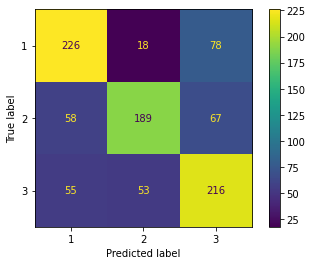


#### results for lowest loss model ####
Accuracy of: 0.6406


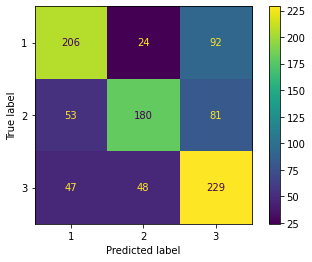


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9948 @ epoch 723
Best training loss (min) 0.071 @ epoch 779

Best validation accuracy (max) 0.875 @ epoch 53
Best validation loss (min) 0.4447 @ epoch 285

#### results for highest accuracy model ####
Accuracy of: 0.6548


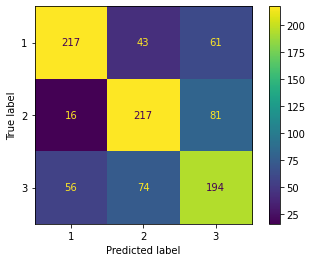


#### results for lowest loss model ####
Accuracy of: 0.6434


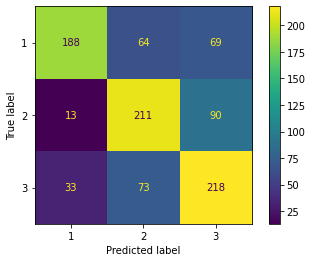


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9933 @ epoch 919
Best training loss (min) 0.1113 @ epoch 919

Best validation accuracy (max) 0.7934 @ epoch 197
Best validation loss (min) 0.5842 @ epoch 96

#### results for highest accuracy model ####
Accuracy of: 0.6932


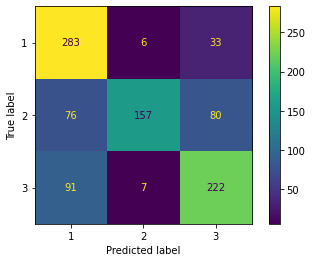


#### results for lowest loss model ####
Accuracy of: 0.6827


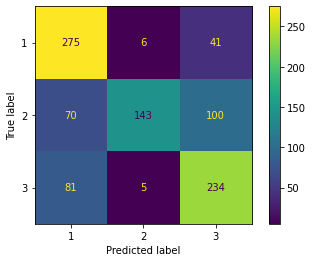

In [8]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Same subject, new session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6545 @ epoch 300                             | 0.8255 @ epoch 169                         | 0.6385                                                     | 0.6594                                                      |
| C           | 0.8663 @ epoch 300                             | 0.4087 @ epoch 337                         | 0.6872                                                     | 0.6632                                                      |
| E           | 0.7431 @ epoch 191                             | 0.6214 @ epoch 191                         | 0.6492                                                     | 0.6492                                                      |

Model performance with the LSTM extension seems to be worse

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_newsession/Loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set


In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.7648 @ epoch 128                        | 0.6107 @ epoch 175                    | 0.6635                                                | 0.6552                                                 |
| C           | 0.7486 @ epoch 6                          | 0.7044 @ epoch 157                    | 0.5985                                                | 0.5746                                                 |
| E           | 0.7182 @ epoch 72                         | 0.7053 @ epoch 80                     | 0.6461                                                | 0.6534                                                 |

Test set performance seems slightly better compared to EEGNet, although not by any statistical means.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/newsubject/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 300 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set


In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 300, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

EEGNet with biderectional LSTM conv:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7497 @ epoch 82                              | 0.6353 @ epoch 47                          | 0.626                                                      | 0.6125                                                      |
| C           | 0.7329 @ epoch 50                              | 0.6575 @ epoch 109                         | 0.6204                                                     | 0.5746                                                      |
| E           | 0.724 @ epoch 240                              | 0.6687 @ epoch 75                          | 0.6136                                                     | 0.6618                                                      |

Test set performance seems slightly better compared to EEGNet, although not by any statistical means.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/newsubject/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset